In [1]:
import csv

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2023-06-26 11:40:44.153894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 各パス指定

In [2]:
# Get the path of the notebook
notebook_dir = %pwd

# Generate the absolute path to the dataset
dataset = os.path.join(notebook_dir, 'utils/keypoint_classifier/keypoint.csv')

# Generate the absolute path to the model save location
model_save_path = os.path.join(notebook_dir, 'utils/keypoint_classifier/hdf5_models/keypoint_classifier.hdf5')


# 分類数設定

In [3]:
NUM_CLASSES = 6

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 1.8448 - accuracy: 0.1875
Epoch 1: saving model to /home/omer/Workspaces/franka_ws/src/robot_control/robot_control/utils/keypoint_classifier/hdf5_models/keypoint_classifier.hdf5
1/1 [==============================] - 0s 433ms/step - loss: 1.8448 - accuracy: 0.1875 - val_loss: 1.7388 - val_accuracy: 0.2105
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 1.7782 - accuracy: 0.2232
Epoch 2: saving model to /home/omer/Workspaces/franka_ws/src/robot_control/robot_control/utils/keypoint_classifier/hdf5_models/keypoint_classifier.hdf5
1/1 [==============================] - 0s 21ms/step - loss: 1.7782 - accuracy: 0.2232 - val_loss: 1.7293 - val_accuracy: 0.2105
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 1.7726 - accuracy: 0.1696
Epoch 3: saving model to /home/omer/Workspaces/franka_ws/src/robot_control/robot_control/utils/keypoint_classifier/hdf5_models/keypoint_classifier.hdf5
1/1 [

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 11ms/step - loss: 0.3145 - accuracy: 0.8684


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 34ms/step
[6.7006429e-03 2.9774445e-01 5.6426173e-01 9.8740030e-04 2.8289601e-04
 1.3002291e-01]
2


# 混同行列

2/2 [==============================] - 0s 2ms/step


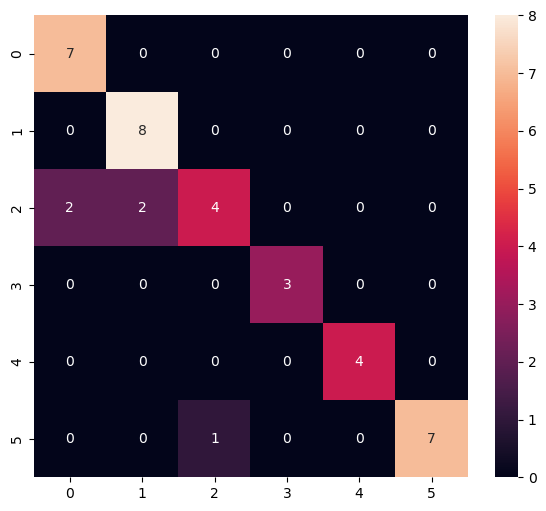

Classification Report
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.80      1.00      0.89         8
           2       0.80      0.50      0.62         8
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      0.88      0.93         8

    accuracy                           0.87        38
   macro avg       0.90      0.90      0.89        38
weighted avg       0.87      0.87      0.86        38



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# Read the current user name from the file
%pwd
script_dir = os.getcwd()
  # get the path of the script
log_file_path = os.path.join(script_dir, 'currentUserLog.txt')  # join the script path with the relative log file path

with open(log_file_path, 'r') as file:
    current_user = file.read().strip()

# Generate the model file path
model_directory = os.path.join(script_dir, 'utils/keypoint_classifier/tflite_models')  # use absolute path for model directory
model_name = f"{current_user}.tflite"
tflite_save_path = os.path.join(model_directory, model_name)

# Convert and save the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as file:
    file.write(tflite_quantized_model)


INFO:tensorflow:Assets written to: /tmp/tmp7778ysk0/assets


INFO:tensorflow:Assets written to: /tmp/tmp7778ysk0/assets
2023-06-26 11:40:57.949598: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-26 11:40:57.949620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 42 µs, sys: 10 µs, total: 52 µs
Wall time: 58.2 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.7006429e-03 2.9774433e-01 5.6426173e-01 9.8740077e-04 2.8289598e-04
 1.3002297e-01]
2
